# Step 5: Select and Train ML Model

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(data_url, sep=";")

In [37]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["quality"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [38]:
wine_features = strat_train_set.drop("quality", axis=1)
wine_labels = strat_train_set["quality"].copy()

In [39]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

transform_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scalar", StandardScaler()),
])

wine_features_tr = transform_pipeline.fit_transform(wine_features)

Its good practice to build a quick baseline model on the preprocessed data and get an idea about the model performance

In [41]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(wine_features_tr, wine_labels)

LinearRegression()

Now that we have a working linear regression model lets evaluate the performance on both training and test data sets

In [42]:
lin_reg.coef_

array([-0.0018089 , -0.18992317, -0.02737418,  0.00281361, -0.08332933,
        0.06587511, -0.12842975, -0.00411272, -0.09157944,  0.13672446,
        0.31694509])

In [43]:
lin_reg.intercept_

np.float64(5.637216575449571)

In [44]:
from sklearn.metrics import mean_squared_error

quality_predictions = lin_reg.predict(wine_features_tr)
mean_squared_error(wine_labels, quality_predictions)

0.4206571060060278

### Mean squared error:
Mean Squared Error is the average of the squared differences between the predicted values and the actual values.

* MSE = 1/n × Σ(quality_predictions - wine_labels)²
* So an MSE of 0.42 means
* On average, our predictions are off by about √0.42 ≈ 0.65 units of wine quality.
* we want the mean squarred error to be as minimum as possible

Lets evaluate its performance on the test set
1. first prepare the test data

In [45]:
wine_features_test = strat_test_set.drop("quality", axis=1)
wine_labels_test = strat_test_set["quality"].copy()

wine_features_test_tr = transform_pipeline.fit_transform(wine_features_test)

quality_predictions_test = lin_reg.predict(wine_features_test_tr)
mean_squared_error(wine_labels_test, quality_predictions_test)

0.3975913087501519

Lets visualize the error between actual and the predicted values

Text(0, 0.5, 'Predicted quality')

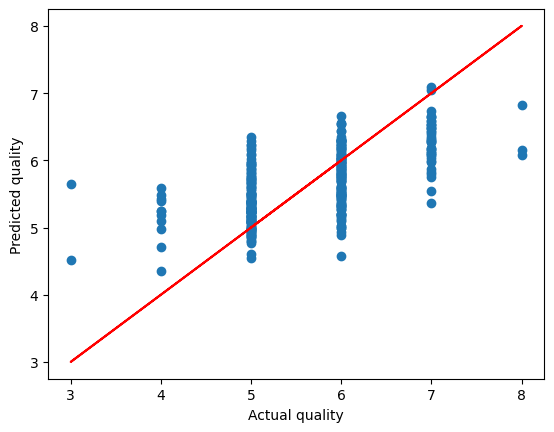

In [46]:
plt.scatter(wine_labels_test, quality_predictions_test)
plt.plot(wine_labels_test, wine_labels_test, "r-")
plt.xlabel("Actual quality")
plt.ylabel("Predicted quality")

### Observations:
* look at the two dots where the actual quality was 3 but our prediction was 4.5 and 5.8
* on the other end when the actual quality was 8 our model predicted as 6, 6.1, 6.8
* but in the middle part the predictions are fairly good
* This model seems to seems to be making mistakes at high and low quality wines

### DecisionTreeRegressor
lets try another model which is DecisionTreeRegressor

In [47]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(wine_features_tr, wine_labels)

DecisionTreeRegressor()

In [48]:
quality_predictions = tree_reg.predict(wine_features_tr)
mean_squared_error(wine_labels, quality_predictions)

0.0

In [50]:
quality_predictions_test = tree_reg.predict(wine_features_test_tr)
mean_squared_error(wine_labels_test, quality_predictions_test)

0.578125

The training error is zero but the test error is 0.58 which means the model is overfitted

Text(0, 0.5, 'Predicted quality')

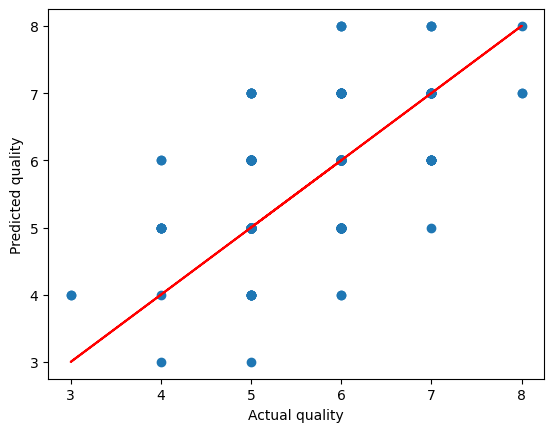

In [51]:
plt.scatter(wine_labels_test, quality_predictions_test)
plt.plot(wine_labels_test, wine_labels_test, "r-")
plt.xlabel("Actual quality")
plt.ylabel("Predicted quality")

we can use cross validation(CV) for robust evaluation of model evaluation

In [53]:
from sklearn.model_selection import cross_val_score

* Cross validation provides a seperate MSE for each validation set
* we can use to estimate the mean MSE as well as the standard deviation
* this helps us to determine how precise is the estimate
* but the additional cost is additional training runs which may be too expensive in some cases

### for linear regression model

In [54]:
def display_scores(scores):
	print("Scores:", scores)
	print("Mean:", scores.mean())
	print("Standard deviation:", scores.std())

scores = cross_val_score(lin_reg, wine_features_tr, wine_labels,
													scoring="neg_mean_squared_error", cv=10)
lin_reg_mse_scores = -scores
display_scores(lin_reg_mse_scores)

Scores: [0.56364537 0.4429824  0.38302744 0.40166681 0.29687635 0.37322622
 0.33184855 0.50182048 0.51661311 0.50468542]
Mean: 0.431639217212196
Standard deviation: 0.08356359730413968


### For Decision tree model

In [65]:
scores = cross_val_score(tree_reg, wine_features_tr, wine_labels,
													scoring="neg_mean_squared_error", cv=10)
tree_reg_mse_scores = -scores
display_scores(tree_reg_mse_scores)

Scores: [0.609375   0.765625   0.6796875  0.4921875  0.5078125  0.625
 0.59375    0.7265625  0.8828125  1.00787402]
Mean: 0.6890686515748031
Standard deviation: 0.15417058865754474


LinearRegression has better MSE and more precise estimation than DecisionTreeRegression

### Random Forest CV
* random forest model builds multiple decision trees on randomly selected features and then average their predictions
* building a model on top of other model is called ensemble learning which is often used to improve the performance of ML models

In [75]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(wine_features_tr, wine_labels)

scores = cross_val_score(forest_reg, wine_features_tr, wine_labels,
													scoring="neg_mean_squared_error", cv=10)
forest_reg_mse_scores = -scores
display_scores(forest_reg_mse_scores)


Scores: [0.36544219 0.42842187 0.31200313 0.32612266 0.22413984 0.30043906
 0.26366406 0.39492187 0.43833672 0.44458268]
Mean: 0.34980740834153545
Standard deviation: 0.07274624656029205


In [76]:
quality_predictions_test = forest_reg.predict(wine_features_test_tr)
mean_squared_error(wine_labels_test, quality_predictions_test)

0.338399375

Text(0, 0.5, 'Predicted quality')

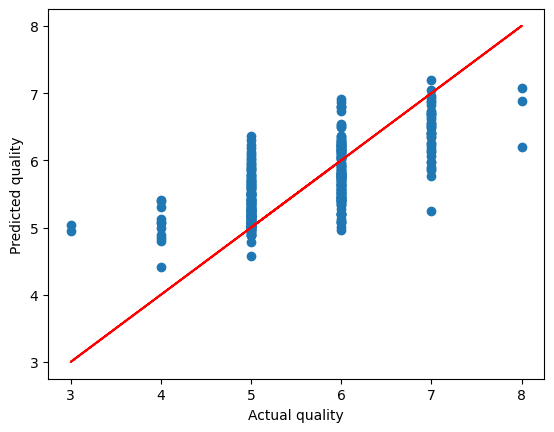

In [77]:
plt.scatter(wine_labels_test, quality_predictions_test)
plt.plot(wine_labels_test, wine_labels_test, "r-")
plt.xlabel("Actual quality")
plt.ylabel("Predicted quality")

* Random forest looks more promising than the other two models
* but still the high and low quality are a problem
* its good practice to build few such models quickly without tuning their hyperparameters and shortlist a few promising models among them.
* Also save the models to the disk in **Python pickle** format

### what next?
* diagonise if our model is underfitting or overfitting
* Underfitting:
    1. Model with more capacity
    2. Less constraints/ regularisatio
* overfitting:
    1. More data
    2. Simpler model
    3. More constraints/ regularisation